# Data Description

***Objective***
The objective is to classify whether a tweet is about a real disaster or not

The file contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself.

Then the text were manually classified whether the tweet referred to a disaster event or not (a joke with the word or a movie review or something non-disastrous).

***Columns***

1. id = A unique identifier for each tweet

2. keyword = A particular keyword from the tweet

3. location = The location the tweet was sent from (may be blank)

4. text = The text of the tweet

5. target = Denotes whether a tweet is about a real disaster (1) or not (0)

# Importing the packages and reading the dataset

In [1]:
# Importing the packages
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving tweets_lyst2640.csv to tweets_lyst2640.csv


In [5]:
import io
disaster = pd.read_csv('tweets_lyst2640.csv')

# Exploring the Dataset

In [6]:
disaster.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [7]:
# Shape of the dataset
disaster.shape

(11370, 5)

In [8]:
# Value counts for Target column
disaster['target'].value_counts()

0    9266
1    2104
Name: target, dtype: int64

# Checking for null values and treating them

In [9]:
# checking for null values
disaster.isnull().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

We could find null values present in location we can fill them with zero as some of the tweets may not be added ***location***

In [10]:
# Replacing null values with zero
disaster['location'] = disaster['location'].fillna(value=0)

In [11]:
# checking again for null values
disaster.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

# Creating Tokenizer

In [12]:
# Creating our list of punctuations
punc = string.punctuation

# Creating our list of stopwords
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Loading parser
parse = English()

# Creating the tokenizer function
def tokenize(token):
    # Creating the token object where all the tokenization functions are applied starting 
    # with parsing
    token_obj = parse(token)
    
    # Lemmatizing each token and converting it into lowercase
    token_obj = [i.lemma_.lower().strip() if i.lemma_!='-PRON-' else i.lower_ for i in token_obj]
    
    # Removing stop words and punctuations
    token_obj = [i for i in token_obj if i not in stopwords and i not in punc]
    
    # Returning the token
    return token_obj
    

# Creating Custom Transformer for cleaning the dataset

In [13]:
# Creating custom transformer using spaCy
class transformer(TransformerMixin):
    def transform(self,X,**transform_params):
        
        # Cleaning the text
        return [clean(i) for i in X]
    # Fitting the transformer
    
    def fit(self,X,y=None,**fit_params):
        return self
    
    # Predicting the transformer
    def get_params(self,deep=True):
        return{}
    
# Basic clean function
def clean(i):
    
    # Removing the spaces and converting all the text into lowercase
    return i.strip().lower()

# Creating Vectorizer

In [14]:
# Creating Count Vectorizer
count_vector = CountVectorizer(tokenizer=tokenize,ngram_range=(1,1))

In [15]:
# Creating TF-IDF Vectorizer
tfidf_vect= TfidfVectorizer( tokenizer=tokenize,use_idf=True, smooth_idf=True, sublinear_tf=False)

# Splitting the dataset into train and test

In [16]:
# Importing train_test split
from sklearn.model_selection import train_test_split

# Assigning X and Y values

x = disaster['text']# the feature we want to analyze
y = disaster['target'] # the labels

# Splitting the values into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 2,test_size = 0.25)

# Creating a Pipeline with Custom Transformer,Vectorizer and ML model

In [17]:
# Importing Random Forest Classifier and fitting the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')

# Importing RandomizedSearchCV and assigning the parameters
from sklearn.model_selection import RandomizedSearchCV
params = {'criterion':['entropy','gini'],'max_depth':range(1,15,2)}

# Fitting the RandomizedSearchCV model
rfc = RandomizedSearchCV(rf,params)

In [18]:
# Creating the pipeline
pipe_rf = Pipeline([('clean',transformer()),
                 ('vectorizer',tfidf_vect),
                 ('model',rfc)])

# Model generation
pipe_rf.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('clean', <__main__.transformer object at 0x7f33cdccf4e0>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_word...
                                                                     min_weight_fraction_leaf=0.0,
                                                                     n_estimators=100,
                                                                     n_jobs=None,
                                                                     oob_score=Fal

# Evaluating the pipeline

In [19]:
# Importing the metrics
from sklearn import metrics

# Predicting with test data
predict = pipe_rf.predict(x_test)

In [20]:
# Model accuracy,precision and recall
print('Accuracy',metrics.accuracy_score(y_test,predict))
print('Precision',metrics.precision_score(y_test,predict))
print('Recall',metrics.recall_score(y_test,predict))
print('F1-Score',metrics.f1_score(y_test,predict))

Accuracy 0.8684488216672529
Precision 0.6506550218340611
Recall 0.58203125
F1-Score 0.6144329896907216


In [21]:
# Confusion matrix
conf_matrix_rf = metrics.confusion_matrix(y_test,predict)
print(conf_matrix_rf)

[[2171  160]
 [ 214  298]]


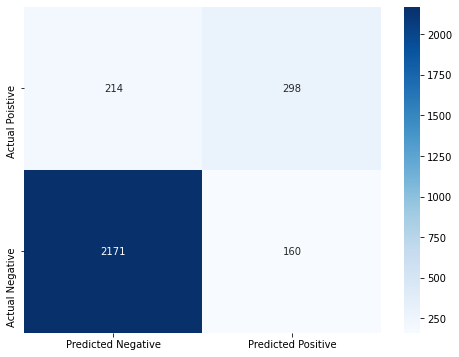

In [22]:
# Plotting the confusion matrix
cfm= conf_matrix_rf
lbl1=["Predicted Negative", "Predicted Positive"]
lbl2=["Actual Negative", "Actual Poistive"]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
ax.set_ylim([0,2])
plt.show()

# Using another ML model in the pipeline

In [23]:
# Importing Support Vector Classifier algorithm
from sklearn.svm import SVC
svc = SVC(class_weight='balanced')

params1 = {'kernel':['linear','rbf','poly','sigmoid'],'C': [0.01, 0.1, 1,10],'gamma': [0.01,0.1,1,10]}

# Fitting the RandomizedSearchCV model
svcc = RandomizedSearchCV(svc,params1)

In [24]:
# Creating the pipeline
pipe = Pipeline([('clean',transformer()),
                 ('vectorizer',tfidf_vect),
                 ('model',svcc)])

# Model generation
pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('clean', <__main__.transformer object at 0x7f33c9706da0>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_word...
                                                  kernel='rbf', max_iter=-1,
                                                  probability=False,
                                                  random_state=None,
                                                  shrinking=True, tol=0.001,
                                                  verbose=

# Evaluating the new model

In [25]:
# Predicting with test data
pred = pipe.predict(x_test)

# Model accuracy,precision and recall
print('Accuracy',metrics.accuracy_score(y_test,pred))
print('Precision',metrics.precision_score(y_test,pred))
print('Recall',metrics.recall_score(y_test,pred))
print('F1-Score',metrics.f1_score(y_test,pred))

Accuracy 0.8821667252901865
Precision 0.6685714285714286
Recall 0.685546875
F1-Score 0.6769527483124397


In [26]:
# Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test,pred)
print(conf_matrix)

[[2157  174]
 [ 161  351]]


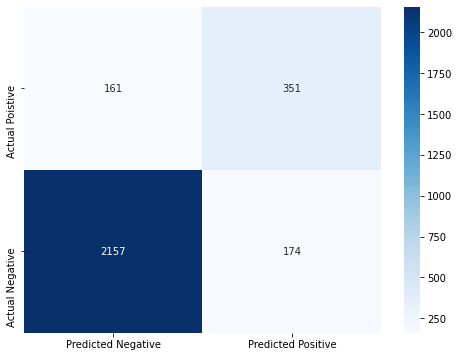

In [27]:
# Plotting the confusion matrix
conf= conf_matrix
lbl1=["Predicted Negative", "Predicted Positive"]
lbl2=["Actual Negative", "Actual Poistive"]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
ax.set_ylim([0,2])
plt.show()